In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import numpy
import torch
import torchvision
import typing
import numpy

from holo.prettyFormats import prettyPrint, prettyTime
from holo.__typing import assertIsinstance

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [4]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper2
import modelsParameters

def cell():
    global handleDatas, train, MoE_models, basicModels, modelsParameters
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    modelsParameters = importlib.reload(modelsParameters)
    MoE_models.paper2 = importlib.reload(MoE_models.paper2)

cell();

In [5]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256, dataAugemnt="basic+degrade")

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10](total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]


In [6]:
print(datasHandler.full_dataset.cachableTransform)
print(datasHandler.full_dataset.finalTransform)

Compose(
      ToImage()
      ToDtype(scale=True)
)
Compose(
      ColorJitter(brightness=(0.65, 1.35), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.03, 0.03))
      Normalize(mean=[0.5, 0.5, 0.5], std=[0.22, 0.22, 0.22], inplace=False)
      RandomHorizontalFlip(p=0.5)
      RandomRotation(degrees=[-15.0, 15.0], interpolation=InterpolationMode.BILINEAR, expand=False, fill=0)
      RandomResizedCrop(size=(32, 32), scale=(0.65, 1.5), ratio=(1, 1), interpolation=InterpolationMode.BILINEAR, antialias=True)
)


In [7]:
datasHandler_noAugments = handleDatas.HandleImagesClassifDatas(
    images=[datasHandler.full_dataset.images[i] for i in datasHandler.dataset_test.indices],
    name=f"copyNoAugments[{datasHandler.name}]", nbClasses=datasHandler.nbClasses,
    trainProp=0.0001, batchSizeTrain=256, batchSizeTest=256, dataAugemnt=None)

loaded copyNoAugments[Merged[Cifar10]](total: 12000), train: 1 [1 batches] | test: 11999 [47 batches]


-0.2463211880531162
0.964236555621028


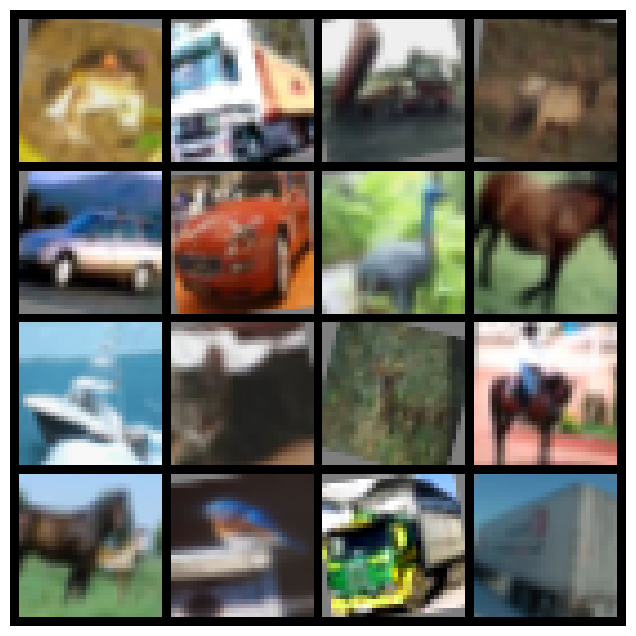

In [8]:
def cell():
    import matplotlib.pyplot as plt
    
    K = 16
    Ks = (K ** 0.5).__ceil__()
    
    plt.figure(figsize=(2*Ks,2*Ks))
    plt.axis('off')
    images = [
        datasHandler.full_dataset.finalTransform(
            datasHandler.full_dataset[i]['image']) for i in range(K)]
    print((sum(img.mean().item() for img in images)/len(images)))
    print((sum(img.std().item() for img in images)/len(images)))
    plt.imshow(torchvision.utils.make_grid(
        images, nrow=Ks, normalize=True, scale_each=False).permute((1, 2, 0)))
    plt.show()

cell(); del cell

In [18]:
model = moeModel = MoE_models.paper2.VisionModelMoe.get_cifar_v2(
    nbClasses=datasHandler.nbClasses, wImp=0.1, wLoad=0.1,
    nbExperts=6, topK=2, modelConfig="large", memoryMode=False).to(device)
lossFunc = torch.nn.CrossEntropyLoss().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

#print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
#basicModels.countLayersparameters(model)
modelsParameters.ModelTreeNode("Model", model).print(showTrainable=False, end=("experts", "gating", "Block_CNN"))

trainer = train.TrainerClassif_MoE2(model=model, optimizer=optim, criterion=lossFunc, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

└── Model: 4_422_614 params
    └── blocks: 4_422_614 params
        ├── Block_CNN[0]: 1_728 params
        ├── Block_CNN[1]: 73_984 params
        ├── Block_CNN[2]: 147_456 params
        ├── Block_CNN[3]: 147_456 params
        ├── Block_CNN[4]: 294_912 params
        ├── Block_CNN[5]: 590_336 params
        ├── Block_FFD_Moe[6]: 3_156_492 params
        │   ├── gating: 3_084 params
        │   └── experts: 3_153_408 params
        ├── Dropout[7]: 0 params
        ├── Flatten[8]: 0 params
        └── Linear[9]: 10_250 params


In [ ]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=25);

Epoch 1, train: (loss: 1.661, accuracy: 38.57%), test: (loss: 1.732, accuracy: 40.44%), lr: 1.0000e-03
Epoch 2, train: (loss: 1.35, accuracy: 51.35%), test: (loss: 1.462, accuracy: 50.25%), lr: 1.0000e-03
Epoch 3, train: (loss: 1.173, accuracy: 58.26%), test: (loss: 1.38, accuracy: 53.11%), lr: 1.0000e-03
Epoch 4, train: (loss: 1.046, accuracy: 63.08%), test: (loss: 1.186, accuracy: 59.80%), lr: 1.0000e-03
doing train batches: 25.00 % done, rem: 8.595 sec 

In [ ]:
def cell_save():
    from pathlib import Path
    pathModel = Path(r"D:\AI_models\MoE_ARMA_project\saved_medV1Cifar_1exp_...")
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optim.state_dict(), 
        "history": trainer.history}
    torch.save(checkpoint, pathModel)

def cell_load():
    from pathlib import Path
    pathModel = Path(r"D:\AI_models\MoE_ARMA_project\saved_medV1Cifar_1exp_...")
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optim.state_dict(), }
    checkpoint = torch.load(pathModel, weights_only=False)
    model.load_state_dict(checkpoint["model"])
    optim.load_state_dict(checkpoint["optimizer"])
    trainer.history = checkpoint["history"]

#cell_save()
#cell_load()
del cell_save, cell_load

In [ ]:
resEval_testNoAugments = trainer.eval_model_classif(
    datas=datasHandler_noAugments.test_cLoader(), 
    nbClasses=datasHandler_noAugments.nbClasses, verbose=True)

In [ ]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
    ttTime, trainTime, testTime = trainer.history.totalTimes()
    print(f"eval (test) with no augments: {resEval_testNoAugments}")
    print(f"totalTime: {prettyTime(ttTime)}, trainTime: {prettyTime(trainTime)}, testTime: {prettyTime(testTime)}")
cell(); del cell

Epoch 1, train: (loss: 1.772, accuracy: 37.24%), test: (loss: 1.682, accuracy: 44.04%), lr: 1.0000e-03
        Epoch 2, train: (loss: 1.392, accuracy: 51.61%), test: (loss: 1.662, accuracy: 45.40%), lr: 1.0000e-03
        Epoch 3, train: (loss: 1.229, accuracy: 57.79%), test: (loss: 1.344, accuracy: 55.89%), lr: 1.0000e-03
        Epoch 4, train: (loss: 1.092, accuracy: 62.76%), test: (loss: 1.305, accuracy: 56.99%), lr: 1.0000e-03
        Epoch 5, train: (loss: 0.9957, accuracy: 66.61%), test: (loss: 1.222, accuracy: 59.74%), lr: 1.0000e-03
        Epoch 6, train: (loss: 0.9176, accuracy: 69.64%), test: (loss: 1.284, accuracy: 60.28%), lr: 1.0000e-03
        Epoch 7, train: (loss: 0.8616, accuracy: 71.64%), test: (loss: 1.132, accuracy: 64.82%), lr: 1.0000e-03
        Epoch 8, train: (loss: 0.801, accuracy: 73.62%), test: (loss: 0.9448, accuracy: 69.09%), lr: 1.0000e-03
        Epoch 9, train: (loss: 0.7461, accuracy: 75.61%), test: (loss: 0.8541, accuracy: 72.27%), lr: 1.0000e-03
   

In [ ]:
def cell():
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        htest2 = assertIsinstance(train.Moe2ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
        for htest in htest2.expertsInsigths:
            print(f"-> RESULT")
            a: numpy.ndarray = htest.meanExpertsGate()
            b: numpy.ndarray = htest.meanPredClassesExpertsGate().std(axis=0)
            print(f"mean: {a.round(3)} (std: {a.std(axis=0).round(3)})")
            print(f"std: {b.round(3)} (mean: {b.mean().round(3)})")
            print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
            print("\n")
        
        rnd = 2
        htests: list[list] = [] # list per MoE of list of htest
        htrains: list[list] = [] # list per MoE of list of htrain
        for i, h in enumerate(trainer.history):
            htest2 = assertIsinstance(train.Moe2ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain2 = assertIsinstance(train.Moe2ExpertsInsigths, h.train.moeExpertsInsigths)
            for i2, (htest, htrain) in enumerate(zip(htest2.expertsInsigths, htrain2.expertsInsigths)):
                if i == 0:
                    htests.append([htest])
                    htrains.append([htrain])
                else: 
                    htests[i2].append(htest)
                    htrains[i2].append(htrain)
        for moe_htrains, moe_htests in zip(htrains, htests):
            for epoch, (htrain, htest) in enumerate(zip(moe_htrains, moe_htests), start=1):
                print(" ->", epoch)
                #print(htest.nbPred.round(rnd))
                #print(htest.nbTruth.round(rnd))
                print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
                print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
                print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
                print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
                print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
                #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
                #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
                print()
    

cell(); del cell

-> RESULT
mean: [0.209 0.141 0.157 0.171 0.198 0.124] (std: 0.03)
std: [0.259 0.212 0.195 0.211 0.172 0.244] (mean: 0.215)
perClassPred: 
[[0.   0.   0.22 0.34 0.45 0.06 0.83 0.06 0.01 0.01]
 [0.03 0.67 0.04 0.02 0.01 0.02 0.05 0.18 0.01 0.41]
 [0.08 0.   0.39 0.39 0.05 0.56 0.03 0.1  0.01 0.  ]
 [0.   0.   0.15 0.13 0.43 0.35 0.04 0.63 0.   0.  ]
 [0.34 0.32 0.17 0.12 0.05 0.01 0.04 0.03 0.3  0.56]
 [0.55 0.   0.03 0.   0.01 0.   0.   0.   0.68 0.01]]


 -> 1
delta (nbPred-nbTruth) per class[test]:
 [ -11  480 -381  836  -97 -605 -228 -376  231  151]
mean experts use[train]: [0.23 0.05 0.22 0.25 0.25 0.  ]
mean experts use[test]: [0.04 0.09 0.37 0.22 0.27 0.  ]
mean experts use per class predicted [test]:
[[0.   0.   0.03 0.03 0.09 0.   0.3  0.01 0.   0.02]
 [0.04 0.25 0.02 0.01 0.03 0.   0.02 0.03 0.04 0.31]
 [0.68 0.03 0.47 0.52 0.41 0.51 0.12 0.65 0.17 0.33]
 [0.01 0.01 0.37 0.44 0.42 0.49 0.43 0.31 0.   0.01]
 [0.27 0.71 0.12 0.01 0.04 0.   0.13 0.   0.79 0.32]
 [0.   0.   0.   0.

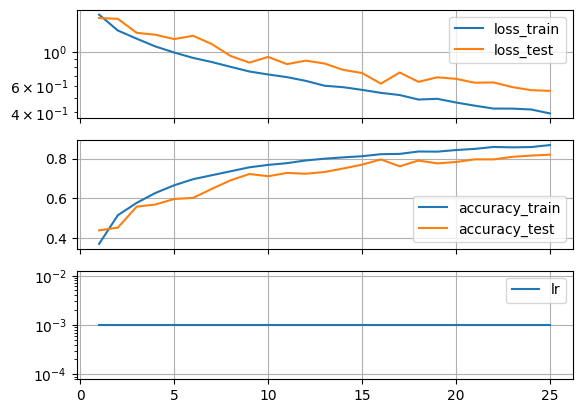

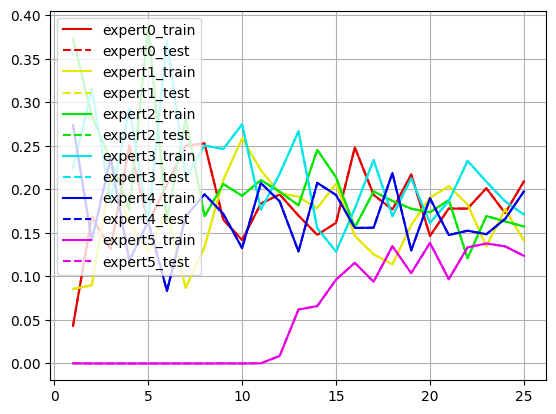

In [ ]:
train.HistoryClassification(trainer.history[:]).plot()
trainer.history.plotMoe2Insigths()

In [ ]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[ 992    5   35   13    7    0    3    5   30   18]
 [  12  978    5    4    1    3    3    3    9   21]
 [  40    3  879   27   26   19   35   13    4    4]
 [  46    7   97  944   86  313  102   59    8   18]
 [  17    1   65   31 1025   46   20   53    1    2]
 [   1    1   24   56   12  764   14   18    0    0]
 [   9    6   35   42   24   31 1025    8    2    1]
 [  12    2   19   27   29   51    3 1062    5    6]
 [  81   10    8   13    3    5   10    6 1051   23]
 [  34  101   12   13    5   19   14   18   34 1113]]

class: 0, precision:89.53%, hitRate: 79.74%
class: 1, precision:94.13%, hitRate: 87.79%
class: 2, precision:83.71%, hitRate: 74.55%
class: 3, precision:56.19%, hitRate: 80.68%
class: 4, precision:81.28%, hitRate: 84.15%
class: 5, precision:85.84%, hitRate: 61.07%
class: 6, precision:86.64%, hitRate: 83.40%
class: 7, precision:87.34%, hitRate: 85.30%
class: 8, precision:86.86%, hitRate: 91.87%
class: 9, precision:81.66%, hitRate: 92.29%

[
    (0.14443931702814952,

In [ ]:
import winsound
winsound.Beep(200, 3000)  # frequency in Hz, duration in ms